In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
from scipy.stats import spearmanr
import numpy as np
import pandas as pd
import deconomix
from tqdm import tqdm

In [2]:
test, train = deconomix.utils.load_example()

# Prepare Test Data
# For each cell type (column), randomly select 50 genes and apply a random regulation factor (between 0.1 and 10)

test_regulated = test.copy()
np.random.seed(42)  # For reproducibility

for celltype in test_regulated.columns.unique():
    genes = test_regulated.index
    selected_genes = np.random.choice(genes, size=200, replace=False)
    regulation_factors = np.random.uniform(0.1, 10, size=200)
    test_regulated.loc[selected_genes, celltype] = (
        test_regulated.loc[selected_genes, celltype].values * regulation_factors[:, np.newaxis]
    )




Raw data already downloaded
Importing Data to Python ...
Using cached, preprocessed data
Done


In [3]:
print(test.size)
print(test.size - (test==test_regulated).sum().sum())

884000
47799


In [4]:
X_ref, Y_mat, C_mat = deconomix.utils.simulate_data(train, n_mixtures = 1000, n_cells_in_mix = 100)
_, Y_test, C_test = deconomix.utils.simulate_data(test_regulated, n_mixtures = 1000, n_cells_in_mix = 100)
model0 = deconomix.methods.DTD(X_ref, Y_mat, C_mat)
model0.run(iterations = 300)

i = 300, loss = -5.824858e+00: 100%|██████████| 300/300 [00:02<00:00, 132.91it/s]


In [5]:
# print(model0.gamma.dtypes)

In [6]:
# model_HPS = deconomix.experimental.HPS2(X_ref, Y_test, model0.gamma, 
#                                        lambdas = np.logspace(-20, 0, num=21))

In [7]:
# model_HPS.run(n_workers=24)

In [8]:


# def plot_results(results):
#     """
#     Plot hyperparameter search results with error bars.

#     Parameters
#     ----------
#     results : list of dict
#         Each dict must have 'lambda', 'loss_raw', and 'loss_weighted' (per-fold results).
#     """
#     import pandas as pd
#     import numpy as np
#     import matplotlib.pyplot as plt

#     # Convert results (list of dicts) to DataFrame
#     results_df = pd.DataFrame(results)

#     # Group by lambda, compute mean and std per lambda
#     grouped = results_df.groupby('lambda').agg({
#         'loss_raw': ['mean', 'std'],
#         'loss_weighted': ['mean', 'std']
#     })
#     #print(grouped)

#     # Prepare X and error bars
#     lambdas = np.array(grouped.index, dtype=float)
#     loss_raw_mean = grouped[('loss_raw', 'mean')].values
#     loss_raw_std = grouped[('loss_raw', 'std')].values
#     loss_weighted_mean = grouped[('loss_weighted', 'mean')].values
#     loss_weighted_std = grouped[('loss_weighted', 'std')].values

#     # Plot with error bars on two separate subplots
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#     # Raw loss subplot
#     axes[0].errorbar(lambdas, loss_raw_mean, yerr=loss_raw_std, 
#                     label='Loss (raw)', marker='o', capsize=3, linestyle='-')
#     axes[0].set_xscale('log')
#     axes[0].set_xlabel('Lambda')
#     axes[0].set_ylabel('Loss (raw)')
#     axes[0].set_title('Loss (raw) vs Lambda')
#     axes[0].legend()

#     # Weighted loss subplot
#     axes[1].errorbar(lambdas, loss_weighted_mean, yerr=loss_weighted_std, 
#                     label='Loss (weighted)', marker='s', capsize=3, linestyle='--')
#     axes[1].set_xscale('log')
#     axes[1].set_xlabel('Lambda')
#     axes[1].set_ylabel('Loss (weighted)')
#     axes[1].set_title('Loss (weighted) vs Lambda')
#     axes[1].legend()

#     plt.tight_layout()
#     plt.show()

In [9]:
# deconomix.experimental.plot_results(model_HPS.results)

In [10]:
gamma_ones = model0.gamma.copy()
gamma_ones.iloc[:,0] = 1. / Y_test.shape[1] * np.ones(model0.gamma.shape[0]) / (Y_test.mean(axis=1))**2
gamma_ones

,gene weights
Genes,
HLA-DRA,0.000061
TYROBP,0.002972
NKG7,0.000108
IGFBP7,0.023944
FCER1G,0.006066
...,...
IMPDH2,0.000142
SAR1A,0.000131
RBMS3,0.005031


In [11]:
model_HPS_gamma_ones =  deconomix.hps.HPS(X_ref,
                                          Y_test, 
                                          lambdas = np.logspace(-20, 0, num=21))

Preparing Job List
Preparing Baseline Model


i = 1, err = inf, loss = 2.297452e+02, loss RSS = 1.146199e-03, loss bias = 2.297441e+02:   0%|          | 0/1000 [00:00<?, ?it/s]

i = 2, err = 0.00e+00 - Convergence reached!:   0%|          | 2/1000 [00:00<01:54,  8.74it/s]                                                 


In [12]:
model_HPS_gamma_ones.run(n_workers=50)

Running jobs: 100%|██████████| 105/105 [08:17<00:00,  4.74s/it]


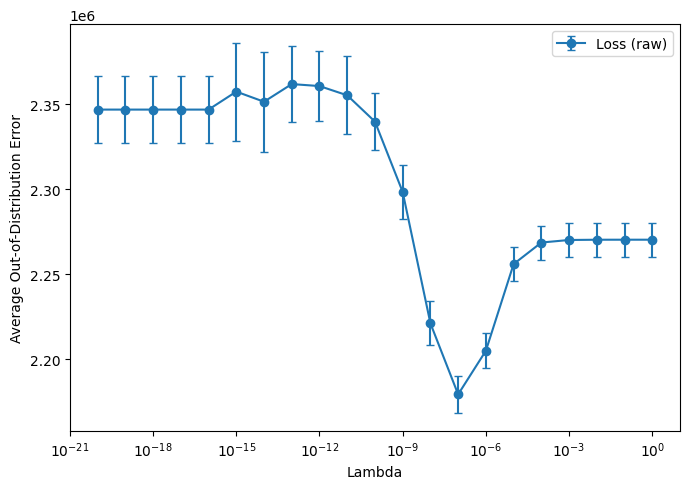

In [16]:
model_HPS_gamma_ones.plot_results()

In [17]:
model_HPS_gamma_ones.get_lambda_1se()

np.float64(1e-06)

In [20]:
model_HPS_gamma_ones.gamma

,0
Genes,
HLA-DRA,0.000061
TYROBP,0.002972
NKG7,0.000108
IGFBP7,0.023944
FCER1G,0.006066
...,...
IMPDH2,0.000142
SAR1A,0.000131
RBMS3,0.005031
